Réaliser par Yanis Zedira et Aymen Djerad , DATA ET INTELLIGENCE ARTIFICIELLE 2

# I) Manipulation de la Donnée
## 1) Télécharger les données fournies

In [25]:
#Importation du module drive depuis google.colab pour accéder à Google Drive
from google.colab import drive

#Montage de Google Drive dans l’environnement Colab
#Cela permet d’accéder aux fichiers stockés sur Drive directement depuis Colab
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2) Charger les données à l'aide de Python

In [2]:
# Importation des modules nécessaires
import os  # Permet de gérer les chemins et les fichiers
import zipfile  # Permet de manipuler les fichiers ZIP

# Définition des chemins :
zip_path = "/content/drive/My Drive/MalariaProject/malaria_hematie_dataset.zip"  # Chemin du fichier ZIP stocké sur Google Drive
output_path = "/content/malaria_hematie_dataset"  # Dossier où les fichiers seront extraits

# Vérification si les fichiers ont déjà été extraits pour éviter une extraction inutile
if not os.path.exists(output_path):
    # Ouverture du fichier ZIP en mode lecture
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Extraction du contenu dans le dossier de destination
        zip_ref.extractall(output_path)
    print("Extraction terminée.")  # Confirmation de l’extraction
else:
    print("Les fichiers sont déjà extraits.")  # Message si les fichiers sont déjà disponibles


Extraction terminée.


## 3) Normaliser les images

In [3]:
infected_path = os.path.join(output_path, "malaria_hematie_dataset", "parasitized")
uninfected_path = os.path.join(output_path, "malaria_hematie_dataset", "uninfected")

print(f"Nombre d'images infectées : {len(os.listdir(infected_path))}")
print(f"Nombre d'images saines : {len(os.listdir(uninfected_path))}")


Nombre d'images infectées : 13779
Nombre d'images saines : 13779


## 4) Encoder les labels

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Chemin du dossier initial
original_data_dir = "/content/malaria_hematie_dataset/malaria_hematie_dataset"
output_base_dir = "/content/malaria_dataset_split"

# Création des dossiers
for folder in ["train", "val", "test"]:
    for category in ["parasitized", "uninfected"]:
        os.makedirs(os.path.join(output_base_dir, folder, category), exist_ok=True)

# Fonction pour répartir les fichiers dans les bons dossiers
def split_and_copy_images(category):
    images = os.listdir(os.path.join(original_data_dir, category))

    train_files, temp_files = train_test_split(images, test_size=0.3, random_state=42)  # 70% train
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)  # 15% val, 15% test

    for file in train_files:
        shutil.copy(os.path.join(original_data_dir, category, file), os.path.join(output_base_dir, "train", category, file))
    for file in val_files:
        shutil.copy(os.path.join(original_data_dir, category, file), os.path.join(output_base_dir, "val", category, file))
    for file in test_files:
        shutil.copy(os.path.join(original_data_dir, category, file), os.path.join(output_base_dir, "test", category, file))

# Répartition pour les 2 classes
split_and_copy_images("parasitized")
split_and_copy_images("uninfected")

print("Répartition des images en 70% train, 15% validation, 15% test terminée.")


Répartition des images en 70% train, 15% validation, 15% test terminée.


## 5) Data augmentation

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet

# Paramètres globaux
batch_size = 16
target_size = (64, 64)

# Générateurs de données (un différent pour chaque modèle)
train_datagen_cnn = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.15
)

train_datagen_vgg = ImageDataGenerator(
    preprocessing_function=preprocess_vgg,  # Prétraitement VGG16
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.15
)

train_datagen_resnet = ImageDataGenerator(
    preprocessing_function=preprocess_resnet,  # Prétraitement ResNet50
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.15
)

# Générateurs sans augmentation pour validation et test
val_test_datagen_cnn = ImageDataGenerator(rescale=1./255)
val_test_datagen_vgg = ImageDataGenerator(preprocessing_function=preprocess_vgg)
val_test_datagen_resnet = ImageDataGenerator(preprocessing_function=preprocess_resnet)

# Générateurs pour CNN
train_generator = train_datagen_cnn.flow_from_directory(
    output_path + "/malaria_hematie_dataset",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = train_datagen_cnn.flow_from_directory(
    output_path + "/malaria_hematie_dataset",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

test_generator = val_test_datagen_cnn.flow_from_directory(
    output_path + "/malaria_hematie_dataset",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Générateurs spécifiques à VGG16 et ResNet50
train_generator_vgg = train_datagen_vgg.flow_from_directory(
    output_path + "/malaria_hematie_dataset",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator_vgg = train_datagen_vgg.flow_from_directory(
    output_path + "/malaria_hematie_dataset",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

test_generator_vgg = val_test_datagen_vgg.flow_from_directory(
    output_path + "/malaria_hematie_dataset",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

train_generator_resnet = train_datagen_resnet.flow_from_directory(
    output_path + "/malaria_hematie_dataset",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator_resnet = train_datagen_resnet.flow_from_directory(
    output_path + "/malaria_hematie_dataset",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

test_generator_resnet = val_test_datagen_resnet.flow_from_directory(
    output_path + "/malaria_hematie_dataset",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

print("Toutes les images sont chargées avec succès pour CNN, VGG16 et ResNet50")


Found 23426 images belonging to 2 classes.
Found 4132 images belonging to 2 classes.
Found 27558 images belonging to 2 classes.
Found 23426 images belonging to 2 classes.
Found 4132 images belonging to 2 classes.
Found 27558 images belonging to 2 classes.
Found 23426 images belonging to 2 classes.
Found 4132 images belonging to 2 classes.
Found 27558 images belonging to 2 classes.
Toutes les images sont chargées avec succès pour CNN, VGG16 et ResNet50


## 6) Afficher les images augmentées

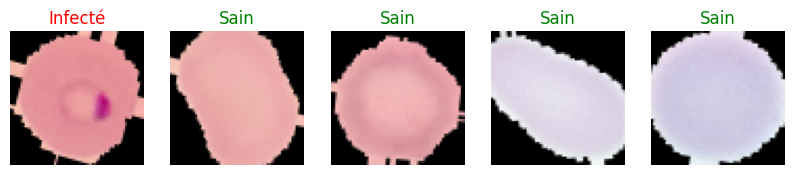

In [6]:
import matplotlib.pyplot as plt
# Vérification que le générateur existe
if "train_generator" not in locals():
    raise ValueError("Assure-toi d'exécuter la cellule qui initialise 'train_generator' avant celle-ci")

# Récupération d'un batch d'images et de leurs labels depuis le générateur d'entraînement
batch = next(train_generator)  # Obtient le prochain lot d'images
images, labels = batch  # Sépare les images et leurs labels

# Affichage des 5 premières images du batch avec leurs labels
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    color = "green" if labels[i] == 1 else "red"
    plt.title("Sain" if labels[i] == 1 else "Infecté", color=color)
    plt.axis("off")
plt.show()


# II) Entraînement de 3 Modèles
## 1) Implémentation de 2 Callbacks

In [7]:
from tensorflow.keras.models import Sequential  #Import du modèle séquentiel
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


model_cnn = Sequential([
    Conv2D(64, (3, 3), activation="relu", padding="same", input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation="relu"),
    BatchNormalization(),
    Dropout(0.4),  # Augmenter le dropout pour éviter l’overfitting

    Dense(1, activation="sigmoid")  # Classification binaire
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 2) Implémentation de 3 CNN pour la Labelisation à l'aide de Keras

In [8]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Charger VGG16 sans les couches Fully Connected
base_model_vgg = VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))

# Geler toutes les couches au départ
base_model_vgg.trainable = False

# Débloquer **les 8 dernières couches** pour le fine-tuning
for layer in base_model_vgg.layers[-8:]:
    layer.trainable = True

# Ajouter un nouveau classifieur
x = GlobalAveragePooling2D()(base_model_vgg.output)
x = Dense(256, activation="relu")(x)  # Nouvelle couche dense
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid")(x)

# Création du modèle final
model_vgg = Model(inputs=base_model_vgg.input, outputs=output)

# Compilation avec un LR faible pour stabiliser le fine-tuning
model_vgg.compile(optimizer=Adam(learning_rate=1e-5), loss="binary_crossentropy", metrics=["accuracy"])

print("VGG16 avec fine-tuning des 8 dernières couches prêt")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
VGG16 avec fine-tuning des 8 dernières couches prêt


In [9]:
base_model_vgg.summary()


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet

# Charger ResNet50 avec les poids ImageNet (sans la partie fully connected)
base_model_resnet = ResNet50(weights="imagenet", include_top=False, input_shape=(64, 64, 3))

#Débloquer les 20 dernières couches pour le fine-tuning
for layer in base_model_resnet.layers[-20:]:
    layer.trainable = True

# Ajout du nouveau classifieur
x = GlobalAveragePooling2D()(base_model_resnet.output)  # Réduction à 2048 features
x = Dense(1024, activation="relu")(x)  # Ajout d'une couche large pour mieux exploiter ResNet
x = Dropout(0.3)(x)
x = Dense(256, activation="relu")(x)  # Réduction progressive
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid")(x)  # Sortie pour classification binaire

# Création du modèle final
model_resnet = Model(inputs=base_model_resnet.input, outputs=output)

# Compilation du modèle avec Adam et un LR bas pour éviter les oscillations
model_resnet.compile(optimizer=Adam(learning_rate=1e-5), loss="binary_crossentropy", metrics=["accuracy"])

print("ResNet50 optimisé avec fine-tuning et prêt à l'entraînement")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
ResNet50 optimisé avec fine-tuning et prêt à l'entraînement


In [11]:
# Importation des callbacks nécessaires pour optimiser l'entraînement des modèles
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# Définition des callbacks pour optimiser l'entraînement des modèles
callbacks_common = [
    # Sauvegarde automatique du modèle avec la meilleure accuracy en validation
    ModelCheckpoint(filepath="best_model.keras", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1),

    # Arrêt précoce si la validation loss cesse de s'améliorer pendant 5 epochs (évite le surapprentissage)
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),

    # Réduction automatique du learning rate en cas de stagnation de la validation loss
    ReduceLROnPlateau(
        monitor="val_loss",  # Surveillance de la validation loss
        factor=0.2,  # Réduction du LR par un facteur de 20%
        patience=2,  # Réduction après 2 epochs sans amélioration
        min_lr=1e-7,  # LR minimal pour éviter qu'il ne devienne trop faible
        verbose=1
    )
]

print("Callbacks configurés avec succès")


Callbacks configurés avec succès


In [12]:
model_cnn.summary()
model_vgg.summary()
model_resnet.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       8,389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,764,289 (33.43 MB)

 Trainable params: 8,762,369 (33.43 MB)

 Non-trainable params: 1,920 (7.50 KB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,3

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 13,110,785 (50.01 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 70, 70, 3)      │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 32, 32, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 32, 32, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 32, 32, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 34, 34, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 16, 16, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 16, 16, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 16, 16, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 16, 16, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 16, 16, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,948,545 (98.99 MB)

 Trainable params: 25,895,425 (98.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [13]:
model_resnet.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 70, 70, 3)      │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 32, 32, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 32, 32, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 32, 32, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 34, 34, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 16, 16, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 16, 16, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 16, 16, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 16, 16, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 16, 16, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,948,545 (98.99 MB)

 Trainable params: 25,895,425 (98.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

## 3) Entraînement des 3 modèles à l'aide des Callbacks implémentés

In [14]:
callbacks_resnet = callbacks_common + [
    ModelCheckpoint(filepath="ResNet50_best.keras", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)
]

history_resnet = model_resnet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    batch_size=32,
    callbacks=callbacks_resnet
)

model_resnet.save_weights("ResNet50.weights.h5")
print(" Entraînement de ResNet50 terminé et poids sauvegardés")


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1465/1465 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7949 - loss: 0.4322
Epoch 1: val_accuracy improved from -inf to 0.94264, saving model to best_model.keras

Epoch 1: val_accuracy improved from -inf to 0.94264, saving model to ResNet50_best.keras
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 187s 85ms/step - accuracy: 0.7949 - loss: 0.4321 - val_accuracy: 0.9426 - val_loss: 0.1594 - learning_rate: 1.0000e-05
Epoch 2/100
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9302 - loss: 0.1857
Epoch 2: val_accuracy improved from 0.94264 to 0.95499, saving model to best_model.keras

Epoch 2: val_accuracy improved from 0.94264 to 0.95499, saving model to ResNet50_best.keras
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 93s 64ms/step - accuracy: 0.9302 - loss: 0.1857 - val_accuracy: 0.9550 - val_loss: 0.1342 - learning_rate: 1.0000e-05
Epoch 3/100
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9461 - loss: 0.1549
Epoch 3: val_accuracy improved from 0.95499 to 0.95547, saving model to best_model.ke

In [15]:
# Ajout d'un ModelCheckpoint spécifique au CNN pour sauvegarder ses meilleurs poids
callbacks_cnn = [
    ModelCheckpoint(filepath="CNN_best.keras", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-7, verbose=1)
]



# Compilation du modèle (AVANT FIT)
model_cnn.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

# Entraînement du modèle CNN
history_cnn = model_cnn.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    batch_size=32,
    callbacks=callbacks_cnn
)




# Sauvegarde des poids finaux du modèle CNN
model_cnn.save_weights("CNN.weights.h5")

print("Entraînement du CNN terminé et poids sauvegardés")


Epoch 1/100
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7503 - loss: 0.5828
Epoch 1: val_accuracy improved from -inf to 0.93514, saving model to CNN_best.keras
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 77s 47ms/step - accuracy: 0.7504 - loss: 0.5827 - val_accuracy: 0.9351 - val_loss: 0.1855 - learning_rate: 1.0000e-04
Epoch 2/100
1464/1465 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9208 - loss: 0.2183
Epoch 2: val_accuracy improved from 0.93514 to 0.93780, saving model to CNN_best.keras
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 67s 45ms/step - accuracy: 0.9208 - loss: 0.2183 - val_accuracy: 0.9378 - val_loss: 0.1763 - learning_rate: 1.0000e-04
Epoch 3/100
1464/1465 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9324 - loss: 0.1897
Epoch 3: val_accuracy improved from 0.93780 to 0.94676, saving model to CNN_best.keras
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 65s 44ms/step - accuracy: 0.9324 - loss: 0.1897 - val_accuracy: 0.9468 - val_loss: 0.1514 - learning_rate: 1.0000e-04
Epoch 4/100
1464/1465 ━━━

In [16]:
callbacks_vgg = callbacks_common + [
    ModelCheckpoint(filepath="VGG16_best.keras", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)
]

history_vgg = model_vgg.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    batch_size=32,
    callbacks=callbacks_vgg
)

model_vgg.save_weights("VGG16.weights.h5")
print(" Entraînement de VGG16 terminé et poids sauvegardés")


Epoch 1/100
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9067 - loss: 0.2260
Epoch 1: val_accuracy did not improve from 0.96612

Epoch 1: val_accuracy improved from -inf to 0.94894, saving model to VGG16_best.keras
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 94s 60ms/step - accuracy: 0.9068 - loss: 0.2259 - val_accuracy: 0.9489 - val_loss: 0.1619 - learning_rate: 1.0000e-05
Epoch 2/100
1464/1465 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9566 - loss: 0.1234
Epoch 2: val_accuracy did not improve from 0.96612

Epoch 2: val_accuracy improved from 0.94894 to 0.95281, saving model to VGG16_best.keras
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 134s 57ms/step - accuracy: 0.9566 - loss: 0.1234 - val_accuracy: 0.9528 - val_loss: 0.1385 - learning_rate: 1.0000e-05
Epoch 3/100
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9573 - loss: 0.1185
Epoch 3: val_accuracy did not improve from 0.96612

Epoch 3: val_accuracy did not improve from 0.95281
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 139s 55ms/step - a

## 4) Sauvegarder les poids des 3 différents modèles


In [17]:
#  Sauvegarde des meilleurs modèles après entraînement
model_cnn.save("CNN_best.keras")
model_vgg.save("VGG16_best.keras")
model_resnet.save("ResNet50_best.keras")

print(" Tous les modèles ont été sauvegardés")


 Tous les modèles ont été sauvegardés


Récuperation des meilleurs poids , et stockage dans un dossier sur google drive afin de pouvoir les importer plus tard sans entrainement à refaire...

In [18]:
from tensorflow.keras.models import load_model

# Montage du drive
from google.colab import drive
drive.mount('/content/drive')

# Chemin vers le dossier contenant les modèles
best_models_path = "/content/drive/My Drive/MalariaProject"

# Chargement des meilleurs modèles
models = {
    "CNN": load_model(f"{best_models_path}/CNN_best.keras"),
    "VGG16": load_model(f"{best_models_path}/VGG16_best.keras"),
    "ResNet50": load_model(f"{best_models_path}/ResNet50_best.keras"),
}

print("Modèles chargés avec succès depuis le dossier MalariaProject dans google drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Modèles chargés avec succès depuis le dossier MalariaProject dans google drive


##II) Test des Modèles


In [19]:
# Récupération des vraies étiquettes des images de test
y_true = test_generator.classes
print("y_true récupéré avec succès")


y_true récupéré avec succès


1723/1723 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step
 Meilleur seuil pour CNN : 0.6443
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step
 Meilleur seuil pour VGG16 : 0.6328
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 44s 23ms/step
 Meilleur seuil pour ResNet50 : 0.6499


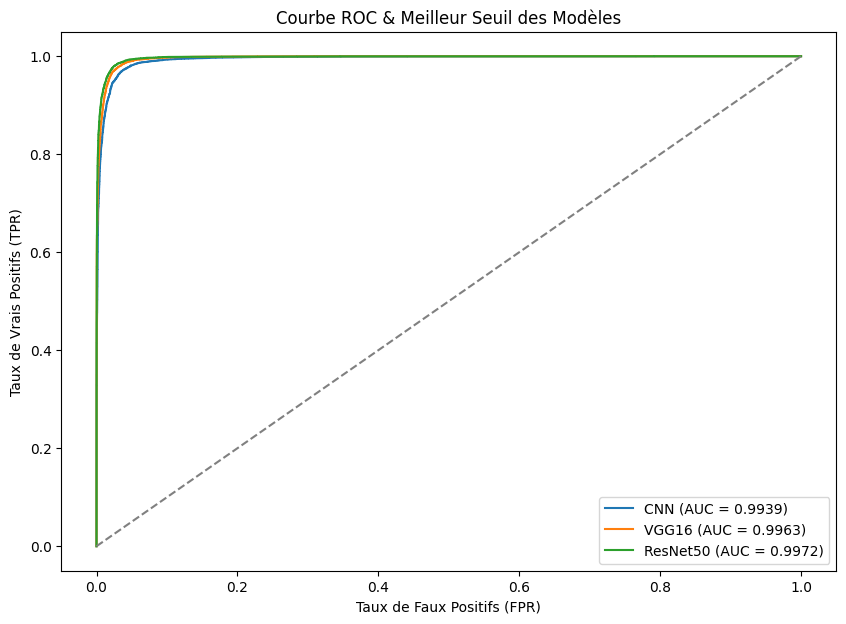

Courbes ROC tracées et seuils optimaux déterminés avec succès


In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 7))

optimal_thresholds = {}  # Dictionnaire pour stocker le meilleur seuil de chaque modèle

for name, model in models.items():
    # Prédictions des probabilités sur le jeu de test
    y_pred_probs = model.predict(test_generator)[:, 0]

    # Calcul des points ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    # Tracé de la courbe ROC
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.4f})")

    # Détermination du meilleur seuil (point le plus proche du coin supérieur gauche)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    optimal_thresholds[name] = optimal_threshold

    print(f" Meilleur seuil pour {name} : {optimal_threshold:.4f}")

# Ligne diagonale (classification aléatoire)
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")

plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbe ROC & Meilleur Seuil des Modèles")
plt.legend()
plt.show()

print("Courbes ROC tracées et seuils optimaux déterminés avec succès")



 Matrice de Confusion - CNN
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step


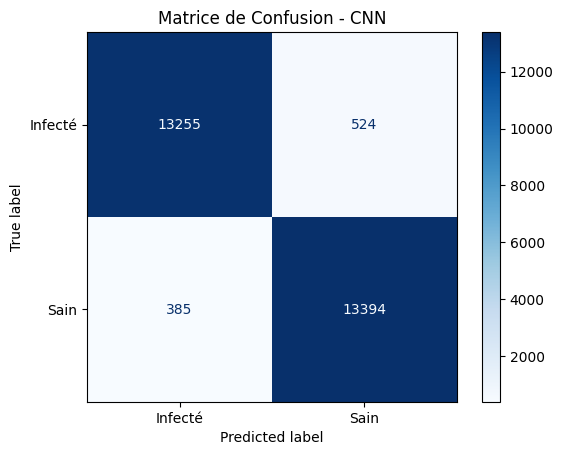


 Matrice de Confusion - VGG16
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 34s 20ms/step


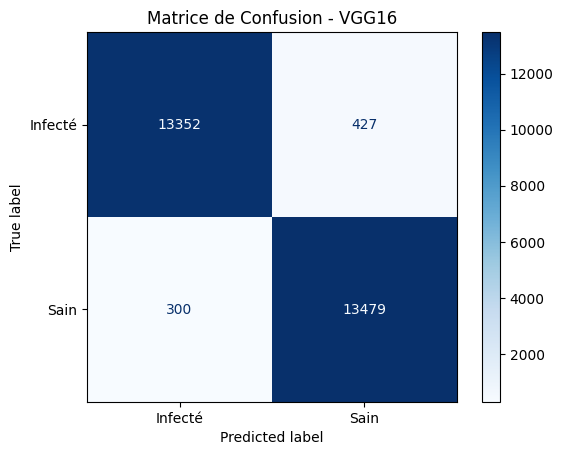


 Matrice de Confusion - ResNet50
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 35s 21ms/step


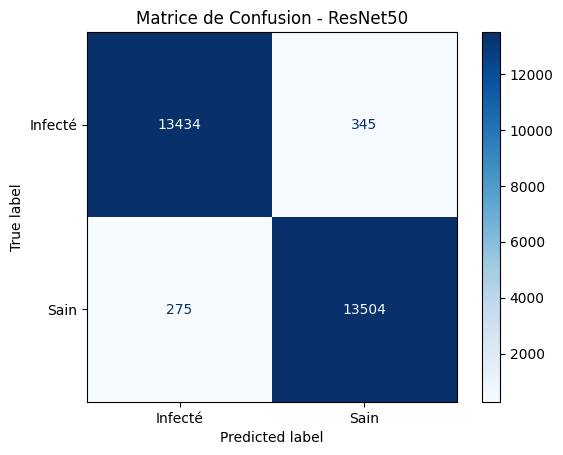

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for name, model in models.items():
    print(f"\n Matrice de Confusion - {name}")

    # Prédictions des classes avec le seuil optimal
    y_pred_probs = model.predict(test_generator)[:, 0]
    y_pred_classes = (y_pred_probs > optimal_thresholds[name]).astype("int32")

    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Infecté", "Sain"])

    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Matrice de Confusion - {name}")
    plt.show()


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Fonction pour évaluer chaque modèle - en respectant la photo que tu m'as envoyée
def evaluer_modele(nom, modele, seuil):
    y_pred_probs = modele.predict(test_generator)[:, 0]
    y_pred_classes = (y_pred_probs > seuil).astype("int32")

    # 1. Exactitude
    accuracy = accuracy_score(y_true, y_pred_classes)

    # 2. Précision (Valeur prédictive positive)
    precision = precision_score(y_true, y_pred_classes)

    # 3. Rappel (Sensibilité)
    recall = recall_score(y_true, y_pred_classes)

    # 4. F1-Score
    f1 = f1_score(y_true, y_pred_classes)

    print(f"\n {nom} - Performances avec seuil {seuil:.4f}:")
    print(f"Accuracy (Exactitude) : {accuracy:.4f}")
    print(f"Precision (Précision) : {precision:.4f}")
    print(f"Recall (Rappel)       : {recall:.4f}")
    print(f"F1-Score              : {f1:.4f}")

# Évaluation de chaque modèle avec le meilleur seuil
for nom, modele in models.items():
    evaluer_modele(nom, modele, optimal_thresholds[nom])


1723/1723 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step

 CNN - Performances avec seuil 0.6443:
Accuracy (Exactitude) : 0.9670
Precision (Précision) : 0.9624
Recall (Rappel)       : 0.9721
F1-Score              : 0.9672
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step

 VGG16 - Performances avec seuil 0.6328:
Accuracy (Exactitude) : 0.9736
Precision (Précision) : 0.9693
Recall (Rappel)       : 0.9782
F1-Score              : 0.9737
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 35s 20ms/step

 ResNet50 - Performances avec seuil 0.6499:
Accuracy (Exactitude) : 0.9775
Precision (Précision) : 0.9751
Recall (Rappel)       : 0.9800
F1-Score              : 0.9776


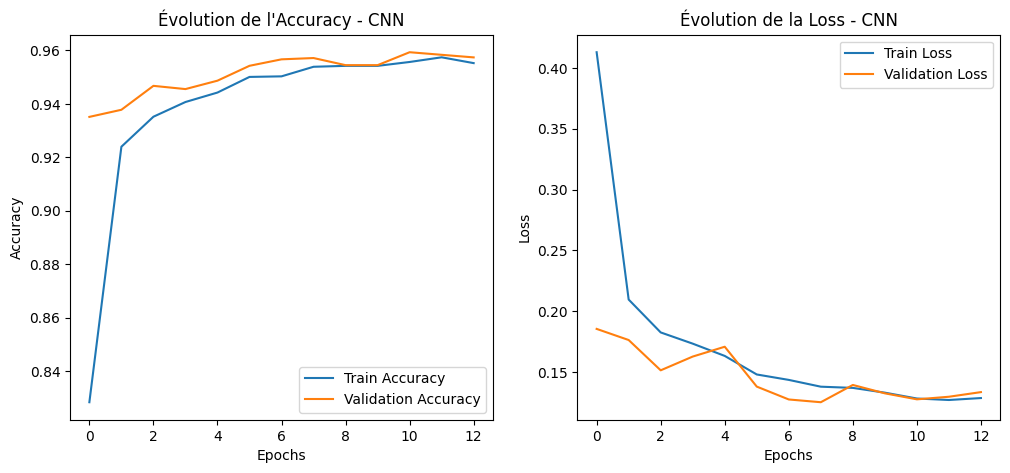

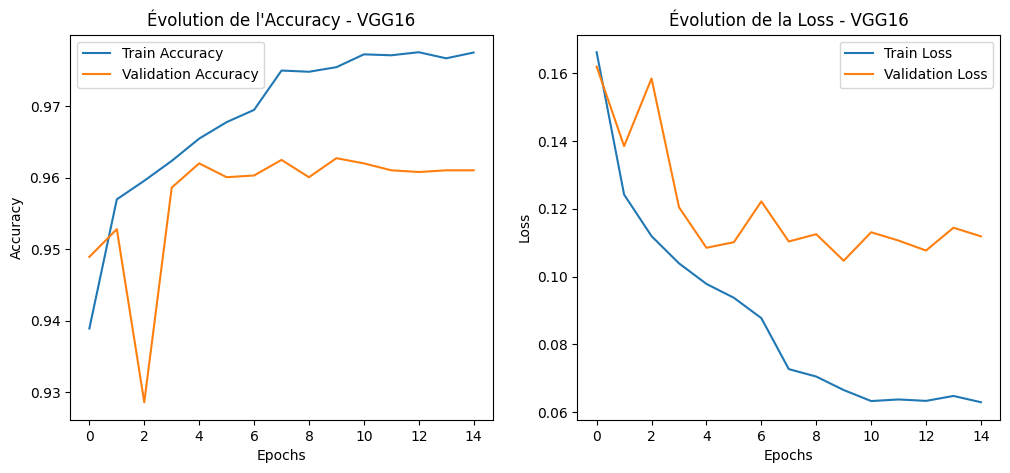

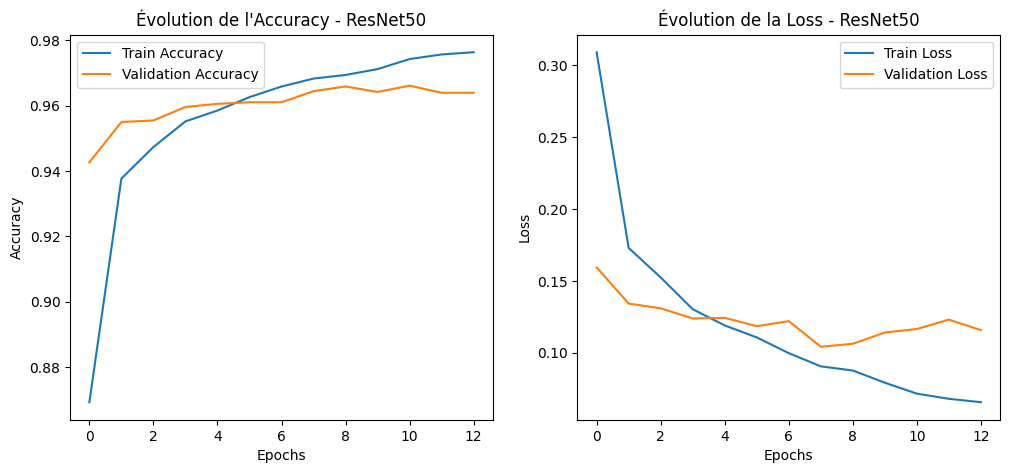

In [23]:
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))

    # Graphique de l'accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(f"Évolution de l'Accuracy - {model_name}")

    # Graphique de la loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Évolution de la Loss - {model_name}")

    plt.show()

# Affichage des courbes pour chaque modèle
plot_training_history(history_cnn, "CNN")
plot_training_history(history_vgg, "VGG16")
plot_training_history(history_resnet, "ResNet50")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step
Image testée : image_21209.png
Vraie classe   : Infecté
Prédiction     : Infecté)


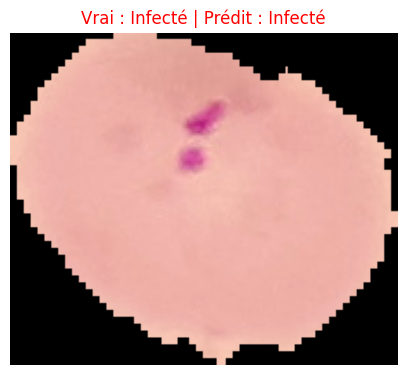

In [24]:
import cv2
import random
import os
import matplotlib.pyplot as plt
import numpy as np

cnn_model = models["CNN"]  # Charger le modèle CNN

# Récupération des images de test
test_dir = "/content/malaria_hematie_dataset/malaria_hematie_dataset"
infected_images = os.listdir(os.path.join(test_dir, "parasitized"))
uninfected_images = os.listdir(os.path.join(test_dir, "uninfected"))

# Sélection aléatoire d'une image
category = random.choice(["parasitized", "uninfected"])
image_name = random.choice(infected_images if category == "parasitized" else uninfected_images)
image_path = os.path.join(test_dir, category, image_name)

# Prétraitement de l'image
img = cv2.imread(image_path)
img_resized = cv2.resize(img, (64, 64))
img_normalized = img_resized / 255.0
img_input = np.expand_dims(img_normalized, axis=0)

# Prédiction du modèle
optimal_threshold = optimal_thresholds["CNN"]
prediction = cnn_model.predict(img_input)[0][0]

#  LABEL DU DATASET
predicted_class = "Non Infecté" if prediction > optimal_threshold else "Infecté"
true_class = "Non Infecté" if category == "uninfected" else "Infecté"

# Affichage des résultats
print(f"Image testée : {image_name}")
print(f"Vraie classe   : {true_class}")
print(f"Prédiction     : {predicted_class})")

# Affichage de l’image avec le résultat
color = "red" if predicted_class == "Infecté" else "green"
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(f"Vrai : {true_class} | Prédit : {predicted_class}", fontsize=12, color=color)
plt.show()
